In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sys
print(sys.version)
sys.path.append('../')

from models.powertrain.bounded_powertrain import Bounded_powertrain
from models.kinematic.ideal_diff_drive import Ideal_diff_drive

3.10.6 (main, Nov  2 2022, 18:53:38) [GCC 11.3.0]


In [3]:
dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/torch_mw_dataset_all.pkl')
input_space_dataframe = pd.read_pickle('/home/dominic/repos/norlab_WMRD/data/marmotte/input_space/input_space_data.pkl')
print(dataframe)

     init_icp_x  init_icp_y  init_icp_z  init_icp_roll  init_icp_pitch  \
0      0.001474   -0.001201    0.000431       0.002204        0.016669   
1      0.001501   -0.001773   -0.000184       0.003869        0.016029   
2      0.001121   -0.001923   -0.000649       0.005148        0.015704   
3      0.001723   -0.002020    0.000421       0.004091        0.017367   
4      0.001195   -0.001311    0.000134       0.004066        0.016252   
..          ...         ...         ...            ...             ...   
150    0.000036   -0.000944    0.001964       0.005497        0.017743   
151   -0.000139   -0.001163    0.002018       0.007033        0.018504   
152    0.000085   -0.000784    0.002248       0.006615        0.018250   
153   -0.000115   -0.000700    0.001955       0.006157        0.018062   
154   -0.000584   -0.000974    0.001081       0.005725        0.016747   

     init_icp_yaw  calib_step  cmd_vx  cmd_omega  encoder_vx  ...  \
0       -3.141202         2.0   -1.50   5.

In [4]:
#generate input-space aware diff-drive model

print(input_space_dataframe)

print(input_space_dataframe['calibrated baseline [m]'].to_numpy()[0])

ideal_diff_drive = Ideal_diff_drive(input_space_dataframe['calibrated_radius [m]'].to_numpy()[0], input_space_dataframe['calibrated baseline [m]'].to_numpy()[0], 0.05)

max_lin_vel = input_space_dataframe['maximum_linear_vel_positive [m/s]'].to_numpy()[0]
max_wheel_vel = np.mean(np.abs(ideal_diff_drive.compute_wheel_vels(np.array([max_lin_vel, 0.0]))))
max_wheel_vel = 11.5

min_lin_vel = input_space_dataframe['maximum_linear_vel_negative [m/s]'].to_numpy()[0]
min_wheel_vel = -np.mean(np.abs(ideal_diff_drive.compute_wheel_vels(np.array([min_lin_vel, 0.0]))))
min_wheel_vel = -11.5


print(min_wheel_vel)

bounded_powertrain = Bounded_powertrain(max_wheel_vel, max_wheel_vel, min_wheel_vel, min_wheel_vel)

#bounded_powertrain = Bounded_powertrain(input_space_dataframe)

   calibrated_radius [m]  calibrated baseline [m]  \
0               0.116702                 0.592723   

   minimum_linear_vel_positive [m/s]  minimum_linear_vel_negative [m/s]  \
0                               0.01                              -0.01   

   minimum_angular_vel_positive [rad/s]  minimum_angular_vel_negative [rad/s]  \
0                                  0.01                                 -0.01   

   maximum_linear_vel_positive [m/s]  maximum_linear_vel_negative [m/s]  \
0                               1.75                               -1.5   

   maximum_angular_vel_positive [rad/s]  maximum_angular_vel_negative [rad/s]  
0                                  3.75                                  -3.5  
0.5927233737094671
[[ 0.05835123  0.05835123]
 [-0.19689195  0.19689195]]
-11.5


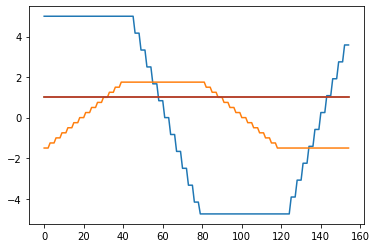

In [5]:
plt.plot(dataframe['cmd_omega'])
plt.plot(dataframe['cmd_vx'])
plt.plot(dataframe['steady_state_mask'])
plt.plot(dataframe['calib_mask'])

In [6]:
def fetch_steady_state_data(data_string, dataframe, steady_state_array):
    data_array = dataframe[data_string].to_numpy()
    return data_array[steady_state_array == True]

steady_state_array = dataframe['steady_state_mask'].to_numpy()

cmd_vx_steady_state = fetch_steady_state_data('cmd_vx', dataframe, steady_state_array)
cmd_omega_steady_state = fetch_steady_state_data('cmd_omega', dataframe, steady_state_array)
print(cmd_vx_steady_state.shape)

encoder_vx_steady_state = fetch_steady_state_data('encoder_vx', dataframe, steady_state_array)
encoder_omega_steady_state = fetch_steady_state_data('encoder_omega', dataframe, steady_state_array)

icp_vx_steady_state = fetch_steady_state_data('icp_vx', dataframe, steady_state_array)
icp_omega_steady_state = fetch_steady_state_data('icp_omega', dataframe, steady_state_array)


(155,)


In [7]:
calibrated_diff_drive_steady_state = np.zeros((cmd_vx_steady_state.shape[0], 2))
bounded_wheel_vels = np.zeros((cmd_vx_steady_state.shape[0], 2))

for i in range(0, cmd_vx_steady_state.shape[0]):
    commanded_wheel_vels = ideal_diff_drive.compute_wheel_vels(np.array([cmd_vx_steady_state[i], cmd_omega_steady_state[i]]))
    bounded_wheel_vels[i, 0], bounded_wheel_vels[i, 1] = bounded_powertrain.compute_bounded_wheel_vels(commanded_wheel_vels[0], commanded_wheel_vels[1])
    calibrated_diff_drive_steady_state[i, :] = ideal_diff_drive.compute_body_vel(bounded_wheel_vels[i, :])

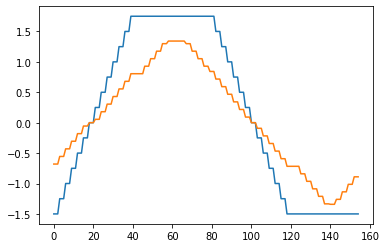

In [8]:
plt.plot(cmd_vx_steady_state)
plt.plot(calibrated_diff_drive_steady_state[:, 0])

In [34]:
n_uniform_samples = 25
n_uniform_samples_sqrt = int(np.floor(np.sqrt(n_uniform_samples)))

full_vels_array = np.zeros((n_uniform_samples, 1, 2))
wheel_vels_range = max_wheel_vel - min_wheel_vel
wheel_vels_step = wheel_vels_range / (n_uniform_samples_sqrt-1)
right_wheel_vel_increasing = True
for i in range(0, n_uniform_samples_sqrt):
    left_wheel_vel = min_wheel_vel + i * wheel_vels_step
    for j in range(0, n_uniform_samples_sqrt):
        if right_wheel_vel_increasing:
            right_wheel_vel = min_wheel_vel + j * wheel_vels_step
        else:
            right_wheel_vel = max_wheel_vel - j * wheel_vels_step
        full_vels_array[i * n_uniform_samples_sqrt + j, 0, :] = ideal_diff_drive.compute_body_vel(np.array([left_wheel_vel, right_wheel_vel]))
    right_wheel_vel_increasing = not right_wheel_vel_increasing
    
print(full_vels_array)

[[[-1.34207833e+00 -9.71445147e-17]]

 [[-1.00655874e+00  1.13212873e+00]]

 [[-6.71039163e-01  2.26425747e+00]]

 [[-3.35519581e-01  3.39638620e+00]]

 [[ 6.93889390e-18  4.52851494e+00]]

 [[ 3.35519581e-01  3.39638620e+00]]

 [[ 3.46944695e-18  2.26425747e+00]]

 [[-3.35519581e-01  1.13212873e+00]]

 [[-6.71039163e-01 -4.85722573e-17]]

 [[-1.00655874e+00 -1.13212873e+00]]

 [[-6.71039163e-01 -2.26425747e+00]]

 [[-3.35519581e-01 -1.13212873e+00]]

 [[ 0.00000000e+00  0.00000000e+00]]

 [[ 3.35519581e-01  1.13212873e+00]]

 [[ 6.71039163e-01  2.26425747e+00]]

 [[ 1.00655874e+00  1.13212873e+00]]

 [[ 6.71039163e-01  4.85722573e-17]]

 [[ 3.35519581e-01 -1.13212873e+00]]

 [[-3.46944695e-18 -2.26425747e+00]]

 [[-3.35519581e-01 -3.39638620e+00]]

 [[-6.93889390e-18 -4.52851494e+00]]

 [[ 3.35519581e-01 -3.39638620e+00]]

 [[ 6.71039163e-01 -2.26425747e+00]]

 [[ 1.00655874e+00 -1.13212873e+00]]

 [[ 1.34207833e+00  9.71445147e-17]]]


(-2.0, 2.0)

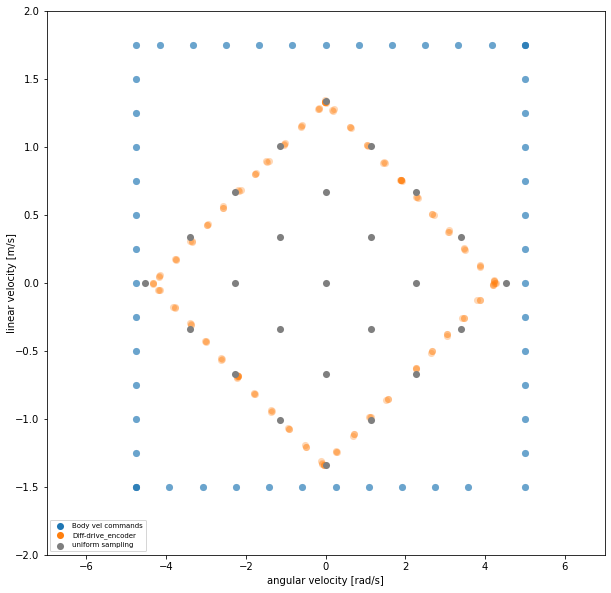

In [35]:
plt.figure(figsize=(10,10))
ax = plt.gca()
fig = plt.gcf()

# df_filtered = autorally_df[(autorally_df.linear_v < 25)] #Super weird ultra large values on linar velocity
# print("filtered {} data points".format(len(autorally_df)-len(df_filtered)))

# max_lv = max(np.abs(df_filtered['linear_v']))
# max_av = max(np.abs(df_filtered['angular_v']))


# meas = ax.scatter(df_filtered['angular_v']/(max_av/2.5), df_filtered['linear_v']/(max_lv/2.5), 
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = 0.05, 
#                   lw=0, 
#                   s=5,
#                   label='Autorally encoders-based body velocities',
#                  rasterized=True)

alpha_plot = 0.3

cmd = ax.scatter(cmd_omega_steady_state, cmd_vx_steady_state, 
                  c = 'tab:blue', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Body vel commands',
                 rasterized=True)

encoder = ax.scatter(encoder_omega_steady_state, encoder_vx_steady_state,
                  c = 'tab:orange', 
                  cmap = 'hot', 
                  alpha = alpha_plot, 
                  lw=0, 
                  s=50,
                  label='Diff-drive_encoder',
                 rasterized=True)

# input_space_aware = ax.scatter(calibrated_diff_drive_steady_state[:, 1], calibrated_diff_drive_steady_state[:, 0],
#                   c = 'tab:red', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='Diff-drive_bounded',
#                  rasterized=True)


uniform_sampling = ax.scatter(full_vels_array[:, 0, 1], full_vels_array[:, 0, 0],
                  c = 'tab:gray', 
                  cmap = 'hot', 
                  alpha = 1, 
                  lw=0, 
                  s=50,
                  label='uniform sampling',
                 rasterized=True)

# icp = ax.scatter(icp_omega_steady_state, icp_vx_steady_state,  
#                   c = 'tab:green', 
#                   cmap = 'hot', 
#                   alpha = alpha_plot, 
#                   lw=0, 
#                   s=50,
#                   label='ICP (lon) and IMU (ang)',
#                  rasterized=True)

ax.set_ylabel('linear velocity [m/s]', labelpad=-2)
ax.set_xlabel('angular velocity [rad/s]')

leg = plt.legend(fontsize=7, loc='best')
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_xlim(-7, 7)
ax.set_ylim(-2, 2.0)

# ax.set_xticks([-1,0,1])
# ax.set_yticks([-1,0,1])
# ax.set_xticklabels([r'$-\dot{\theta}_{max}$', '0', r'$\dot{\theta}_{max}$'])
# ax.set_yticklabels([r'$-v_{max}$', '0', r'$v_{max}$'])

# fig.subplots_adjust(left=.15, bottom=.17, right=.98, top=.98)
# fig.set_size_inches(width, height)

# full_run_dataframe = pd.read_pickle('/media/dominic/462D-1EE8/rosbags/doughnut_calibs/warthog/depot_2/extracted_data/data.pkl')

print(full_run_dataframe)

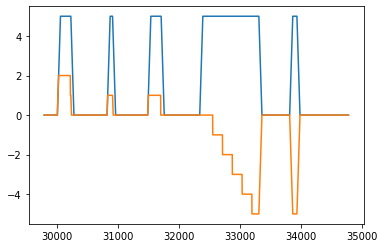

In [63]:
plt.plot(full_run_dataframe['cmd_vel_x'][-5000:])
plt.plot(full_run_dataframe['cmd_vel_omega'][-5000:])

(4999,)


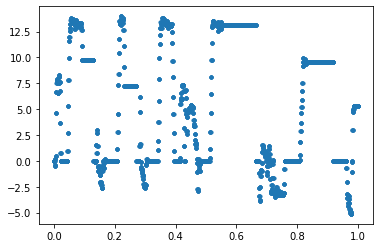

In [62]:
print(np.linspace(0,1, 4999).shape)

plt.scatter(np.linspace(0, 1, 5000), full_run_dataframe['meas_right_vel'][-5000:], s=10)
# plt.plot(full_run_dataframe['cmd_right_vel'][-5000:])